In [21]:
import os
import shutil as sh
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import holidays
from matplotlib.colors import ListedColormap
%matplotlib inline


# Prompt 1
Suppose you own one share of company 'XYZ'. Suppose that today's price is \\$1.00. Every business day there is a 0.005 chance that the stock will go up by \\$0.10, a 0.005 chance that the stock will go down by \\$0.05 and a 0.0001 chance that the company goes bankrupt (i.e., the stock price goes to \\$0.00). 

Write a function called **q1** to calculate the expected value of this stock on a specific date? In particular, conduct a Monte Carlo simulation 10,000 times, assuming that if the price reaches \\$0.00 at any point in time the company goes bankrupt.

- **Input**: a string representing a particular date of interest (e.g., "01/07/2025")
- **Output**: the expected value

*Hint: [pandas provides a way to determine if a day is a holiday](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#holidays-holiday-calendars)*

In [22]:


# Function to check if a date is a weekend
def is_weekend(d):
    return d.weekday() >= 5  # 5 is Saturday, 6 is Sunday
# Function to check if a date is a holiday
def is_holiday(d, holiday_set):
    return d in holiday_set
def q1(date_string):
    date_format = '%d/%m/%Y'
    today = date.today()
    target_date = datetime.strptime(date_string, date_format).date()
    #Get the list of holidays for the given country
    holiday_list = holidays.CountryHoliday('US', years=[today.year, target_date.year])
    holiday_set = set(holiday_list.keys())
    #update for the number of simulations
    nsim=10000
    daily_price_series = []
    probabilities = [.005, .0005, .0001,.9944]
    states = [.10,-.05, None ,0]
    n = (target_date - today).days
    #start simulations
    for simulation in range(nsim):
        daily_prices = []
        price = 1
        current_date = today
        for day in range(n):
            # Skip weekends and holidays
            while is_weekend(current_date) or is_holiday(current_date, holiday_set):
                current_date += timedelta(days=1)
            daily_prices.append(price)
            next_state = np.random.choice(states, p = probabilities)
            if next_state is None:
                price = 0
                break
            else:
                price += next_state
            # Move to the next day
            current_date += timedelta(days=1)
        daily_price_series.append(daily_prices)
    # Calculate the expected value from the final prices, getting the last price
    final_prices = [prices[-1] for prices in daily_price_series]
    expected_value = round(np.mean(final_prices),2)
    # Plotting the distribution of prices
    plt.hist(final_prices, edgecolor = 'k', alpha = .7)
    plt.axvline(expected_value, color = 'red', linestyle = 'dashed', linewidth = 1, label = "Expected Value")
    plt.legend()
    plt.title(f'Frequency Distribution of {nsim} Price Simulations')
    plt.xlabel('Final Price')
    plt.ylabel('Frequency')
    # save the graph as a PDF file
    plt.savefig('varga131_econ577_hw5_q1.pdf')
    plt.show()
    
    return f'the EV after {nsim} simulations is ${expected_value}' 

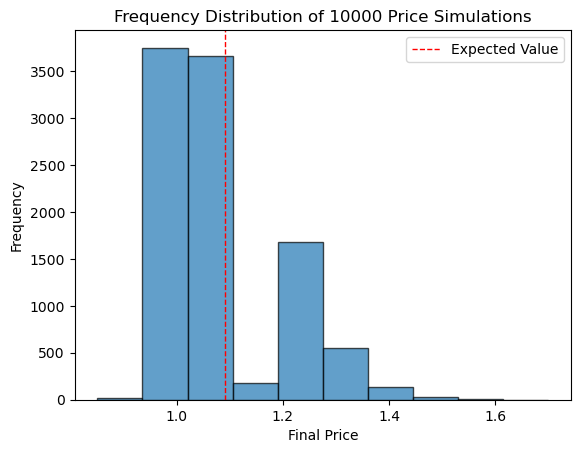

'the EV after 10000 simulations is $1.09'

In [23]:
q1("01/07/2025")

# Prompt 2

The historical volatility of a stock is an important measurement of the risk of the investment. A stock with a relatively stable price has low volatility. A highly volatile stock is riskier but may also yield higher returns. There are many measures of volatility. The most common one is the standard deviation of a stock price; however, it doesn't tell you how volatile your stock is in comparison with the systematic risk of the entire market. To measure the relative volatility of a stock, traders use the Beta coefficient. 

In this homework question, we will calculate a simplified version of the beta coefficient and compare the Beta coefficients between two leading stocks in the health center. Use the beta coefficient to compare the riskiness of these two stocks and use a permutation test to decide how significant the difference is. 

In StockPrice_5Year_Weekly.csv, you will find the 5-year weekly price of S&P 500, Pfizer, and Johnson Group. We will use the S&P 500 as the market benchmark. 


- **Input**: percentile (integer between 0 and 100)
- **Output**: 
    1. a pdf figure saved to file username_q4.pdf (saved to the output folder)
        - Make sure that your graph contains axis labels and proper legends
    2. return the two-sided test p-value

*Make sure that "StockPrice_5Year_Weekly.csv" is in the data folder. 

To calculate the Beta coefficient of a stock market, you need to follow these steps:
1. Calculate the weekly return of all three stocks, $R_{SP500}$, $R_{Pfizer}$, $R_{Johnson}$:

    $$ R_{stock} = ln(\frac{price_{t}}{price_{t-1}})$$
    
2. Calculate the monthly Beta coefficients for Pfizer and Johnson, using S&P 500 as the benchmark. The Beta coefficient is defined as 

$$ \beta = \frac{Covariance(R_{benchmark}, R_{stock})}{Variance(R_{benchmark})} $$

    You can find an example of calculating the Beta coefficient in excel from this link: https://financetrainingcourse.com/education/2011/04/market-risk-metrics--beta-with-respect-to-market-indices/

    Below, you will also find a sample code to calculate the Beta coefficient in Python. Feel free to modify the code for your calculation. 

    For simplicity, disregard the calendar month, use every 4 weekly price changes to calculate the monthly beta coefficients. That is month 1's beta is calculated based on observation 0 to 3, month 2's beta is based on observation 4 to 7... 

3. Once you calculate the monthly Beta coefficients, test whether the nth Percentile monthly Beta coefficitent of Pfizer is different from the nth Percentile monthly Beta coefficient of Johnson. Use the permutation test to generate 10,000 random permutations for each group. 

Reference: https://www.investopedia.com/terms/b/beta.asp 



In [24]:
def q3(percentile):
    #read data in
    data = pd.read_csv('StockPrice_5Year_Weekly.csv')
    #create different arrays for the SP, Pfizer, and Johnson
    SP_weeklyprice = []
    P_weeklyprice = []
    J_weeklyprice = []
    for index, row in data.iterrows():
        #for some reason the SP500 data requires different processing
        sp500_price = int(float(row['S&P 500'].replace(',', '')))  
        pfzier_price = int(row['Pfizer']) 
        johnson_price = int(row['Johnson'])
        SP_weeklyprice.append(sp500_price)
        P_weeklyprice.append(pfzier_price)
        J_weeklyprice.append(johnson_price)
    #combine all data into one array and create empty arrays
    stock_prices = np.array([SP_weeklyprice,P_weeklyprice,J_weeklyprice])
    PC = np.empty(3, dtype=object)  # Create an empty array of objects
    stock_returns = np.empty(3, dtype=object)  # For log returns
    for i in range(3):
        pct = pd.Series(stock_prices[i]).pct_change().dropna()
        PC[i] = pct
        stock_returns[i] = np.log(PC[i]+1)
    #create a function to calculate beta for both stocks
    def weekly_beta_calc(stock_returns,market_returns):
        beg_week = 0
        end_week = 4
        month = 1
        beta_array = []
        while beg_week + 4 <= len(stock_returns):
            end_week = beg_week+4
            cov_matrix = np.cov(stock_returns[beg_week:end_week], market_returns[beg_week:end_week])
            beta_month = cov_matrix[0,1] / cov_matrix[1,1]
            beg_week += 4
            beta_array.append(beta_month)
        return beta_array
    #calculating beta...
    monthly_beta_pfizer = weekly_beta_calc(stock_returns[1],stock_returns[0])
    monthly_beta_johnson = weekly_beta_calc(stock_returns[2],stock_returns[0])
    #getting the nth percentile monthly beta
    beta_pfizer_nth = np.percentile(monthly_beta_pfizer,percentile*100)
    beta_johnson_nth = np.percentile(monthly_beta_johnson,percentile*100)    
    # Calculate original statistic
    observed_diff = beta_pfizer_nth - beta_johnson_nth
    # Combine beta coefficients for permutation testing
    combined_betas = np.concatenate([monthly_beta_pfizer, monthly_beta_johnson])
    # Perform permutation test
    num_permutations = 10000
    perm_diffs = []
    for i in range(num_permutations):
        np.random.shuffle(combined_betas)
        perm_beta_pfizer = combined_betas[:len(monthly_beta_pfizer)]
        perm_beta_johnson = combined_betas[len(monthly_beta_johnson):]
        perm_diff = np.mean(perm_beta_pfizer) - np.mean(perm_beta_johnson)
        perm_diffs.append(perm_diff)
    # Calculate p-value
    perm_diffs = np.array(perm_diffs)
    p_value = (np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)))/num_permutations
    #plotting the data
    plt.hist(perm_diffs, bins = 30, edgecolor = 'k', alpha = .7)
    plt.axvline(observed_diff, color = 'red', linestyle = 'dashed', linewidth = 1, label = "Observed Difference")
    plt.legend()
    plt.title('Permutation Distribution of Differences in Pfizer and Johnson Stock')
    plt.xlabel('Difference in Means')
    plt.ylabel('Frequency')
    # save the graph as a PDF file
    plt.savefig('varga131_econ577_hw5_q3.pdf')
    plt.show()
    
    return f'Observed Difference in Means: {round(observed_diff,2)} P-value: {p_value}'

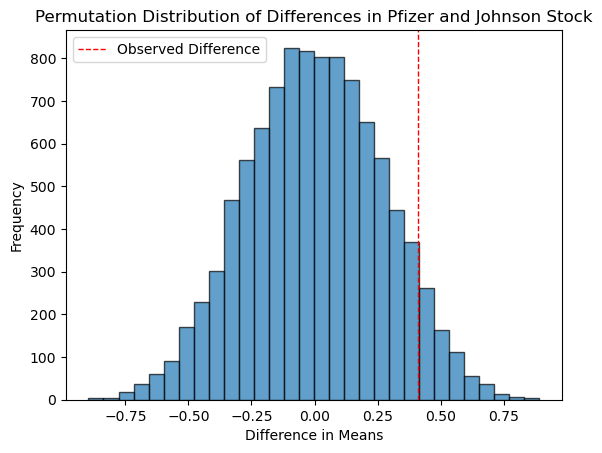

'Observed Difference in Means: 0.41 P-value: 0.1335'

In [25]:
q3(.75)

# Prompt 3
Implement Shelling's (1969) model on a 2-D 10x10 grid as discussed in the lecture. Specifically, compare the overall segregation between the case when the threshold is .35 and the case when the threshold is .65.  To do this, carry out 10,000 simulations to of 100 iterations (i.e., for each simulation give each agent 100 opportunities to move).


- **Inputs**: three arrays. The first array provides the agent types (e.g., [0,1,2] with 0 representing empty spot), the second array provides proportions of each type (e.g., [.10,.6,.3]), the third array provides thresholds for comparison (e.g., [.35, .65])
- **Output**: list of tuples, where each tuple provides the mean and standard deviation of the segregation metric for one threshold (e.g., the output for two thresholds would be in the format [(mean1,std1),(mean2,std2)])

Hints:
1. Start from changing the 1D "Environment" class defined in class to a 2D class. To do so, instead of defining the "width" of the line, you want to define both the width and the length of your grid. In the HW, start with a 2D grid = 10x10    
2. Define the seggregation as the average proportion of neighbors that have the same race as self for all agents. 

In [26]:
class Agent:
    ''' Class definition of the Agent in Schelling model '''
    
    def __init__(self, row, col, race, neighbors, threshold):
        ''' Initialize agent. '''
        self.loc = (row, col)  # Store as a tuple (row, col)
        self.race = race
        self.neighborhood = neighbors
        self.threshold = threshold
        
    def satisfied(self): 
        ''' Returns True or False depending if the threshold is met '''
        return np.mean((self.neighborhood == self.race)) > self.threshold
        
    def moveToNewLoc(self, newRow, newCol, newNeighbors): 
        ''' Updates the agent's location and neighborhood '''
        self.loc = (newRow, newCol)
        self.neighborhood = newNeighbors
        
    def getSegregationMetric(self):
        return np.mean((self.neighborhood == self.race))
    
    def __repr__(self):
        return f"Loc: {self.loc} Race: {self.race} Neighbors: {self.neighborhood}"


class Environment:
    ''' Class definition of the Environment of Schelling 1D model'''
    
    def __init__(self, races, props, size = 10, threshold=1/3, max_iter=100):
        ''' Initialize environment.
                races -- array of races (e.g., [0,1,2]) with 0 denoting an empty space
                props -- proportion of races
                width -- width of the line
                threshold -- similarity threshold
                max_iter -- maximum number of iterations
        '''
        
        self.width = size
        self.height = size
        self.races = races  
        self.props = props        
        self.threshold = threshold
        self.max_iter = max_iter
        self.grid = np.zeros((self.height, self.width))  # 2D grid
        self.agents = []
        self.available_locs=[]
        self.all_satisfied=False
        self.resetGrid()
    
    def resetGrid(self):
        self.grid = np.zeros((self.height, self.width))
        self.available_locs = [(r, c) for r in range(self.height) for c in range(self.width)]
    
        for i in range(1, len(self.races)):
            num_to_sample = int(self.props[i] * self.width * self.height)
            num_to_sample = min(num_to_sample, len(self.available_locs))  # Ensure we don't sample too much
    
            if num_to_sample > 0:
                loc_indices = np.random.choice(len(self.available_locs), size=num_to_sample, replace=False)
                
                # Create a new list of available locations excluding the sampled ones
                new_available_locs = []
                for idx, loc in enumerate(self.available_locs):
                    if idx not in loc_indices:
                        new_available_locs.append(loc)
                    else:
                        row, col = loc
                        self.grid[row, col] = self.races[i]
    
                self.available_locs = new_available_locs  # Update available locations
    
        self.agents = []
        for r in range(self.height):
            for c in range(self.width):
                if self.grid[r, c] > 0:
                    neighbors = self.get_neighbors(r, c)
                    self.agents.append(Agent(r, c, self.grid[r, c], neighbors, self.threshold))
        #print("Grid after initialization:")
        #print(self.grid)
        #print("Available locations after initialization:")
        #print(self.available_locs)

                
    
    def get_neighbors(self, row, col):
        neighbors = []
        for dr in [-1, 0, 1]:  # Change in row
            for dc in [-1, 0, 1]:  # Change in column
                if (dr != 0 or dc != 0):  # Skip the current cell
                    # Check if the neighbor is within grid boundaries
                    if 0 <= row + dr < self.height and 0 <= col + dc < self.width:
                        neighbors.append(self.grid[row + dr, col + dc])
        return np.array(neighbors)

    
    def oneMoveEach(self): #Go through each agent and see it is satisfied. If not move it to one of the available spots
        self.all_satisfied = True #set it to true, if encounter anyone that is not satisfied then set it to false
        for a in self.agents:
            if not a.satisfied():
                self.all_satisfied = False
                oldLoc= a.loc
                # Clear the old location on the grid (this doesn't affect available locations yet)
                self.grid[oldLoc[0], oldLoc[1]] = 0
            
                # Select a new location from available locations
                newLoc = self.available_locs[np.random.randint(len(self.available_locs))]
                self.grid[newLoc[0], newLoc[1]] = a.race  # Move the agent to the new location
            
                # Remove the new location from available locations
                self.available_locs.remove(newLoc)  # Now that the agent has moved, remove the new location
            
                # Since we're moving the agent, we should add back the old location to available locations
                self.available_locs.append(oldLoc)  # Add old location back to available spots
            
                # Update neighborhood for the moved agent
                newNeighbors = self.get_neighbors(newLoc[0], newLoc[1])  # Get neighbors for the new location
                a.moveToNewLoc(newLoc[0], newLoc[1], newNeighbors)  # Update agent's location and neighborhood

            
    def plot_grid(self):
        cmap_array = ListedColormap(['grey', 'red', 'blue'])
        plt.imshow(self.grid, cmap= cmap_array, interpolation='nearest')
        plt.colorbar(label='Race')
        plt.title('Schelling Model Grid')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.show()
    
    
    def runUntilConverged(self):
        step=0
        while not self.all_satisfied and step<=self.max_iter:
            #print(step)
            self.oneMoveEach()
            step = step + 1
            
    def getPopulationMetric(self):
        self.popMetric=np.array([a.getSegregationMetric() for a in self.agents])
        return self.popMetric.mean()
            
    def __repr__(self):
        return str(self.grid)            
    def __str__(self):
        return str(self.grid)

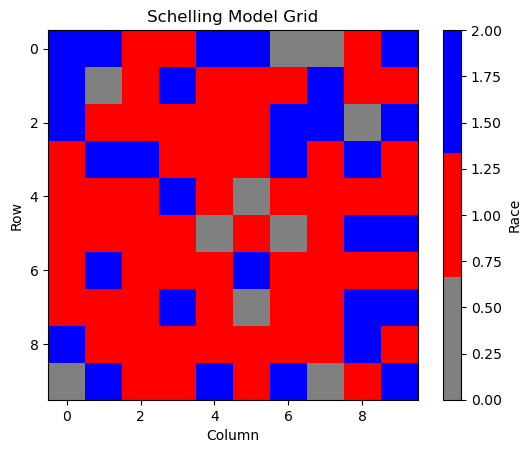

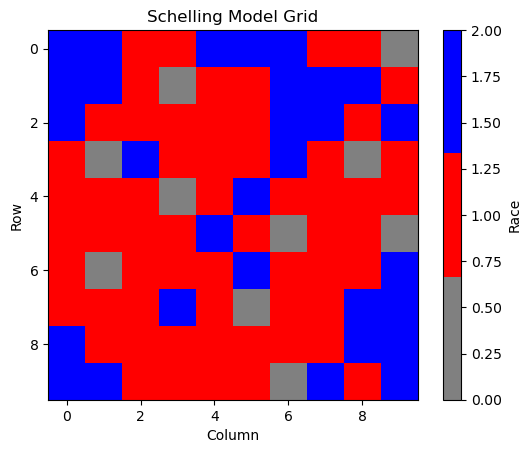

In [27]:
#Creating Parameters
agent_types = np.array([0,1,2])
agent_props = np.array([.1,.6,.3])
compt_thresh = np.array([.35,.65])

e1 = Environment(agent_types, agent_props)
e1.plot_grid()
e1.runUntilConverged()
e1.plot_grid()